In this notebook we try to apply py0 to do inference on the location of patient-zero in the state of Oregon, given a set of weekly average observations coming from compartments I and R. Using MaxEnt, we also reweight the trajectories based on the mentioned observations and do a prediction of how the infection spreads in the counties observed.

In [1]:
!pip install geoplotimport py0
import maxent
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
import networkx as nx
import tensorflow as tf
import pickle

In [2]:
# Loading data 
# Obtained from https://docs.google.com/spreadsheets/d/1-jfX8RL3ZvufIcJKjyST4neLHGT9l2vB/edit#gid=269602771
OR_data = pd.read_excel('data/OR_state_and_county_data_2020.xlsx')
OR_data = OR_data.drop(0)
OR_data
population = list(OR_data['POP20'])
area = list(OR_data['AREALAND20'])
patches = list((OR_data['NAME']))

In [3]:
# Loading data 
# https://www.census.gov/data/tables/2015/demo/metro-micro/commuting-flows-2015.html
OR_mobility_data = pd.read_excel('data/census_mobility_flows.xlsx',
                                 skiprows=6)
non_OR = np.where(OR_mobility_data['State Name']!='Oregon')[0]
OR_mobility_data = OR_mobility_data.drop(non_OR).reset_index()
non_OR = np.where(OR_mobility_data['State Name.1']!='Oregon')[0]
OR_mobility_data = OR_mobility_data.drop(non_OR).reset_index()
OR_mobility_data

,level_0,index,State FIPS Code,County FIPS Code,State Name,County Name,State FIPS Code.1,County FIPS Code.1,State Name.1,County Name.1,Workers in Commuting Flow,Margin of Error
0,14,96109,41,1.0,Oregon,Baker County,41.0,1.0,Oregon,Baker County,5528.0,301.0
1,15,96110,41,1.0,Oregon,Baker County,41.0,19.0,Oregon,Douglas County,5.0,8.0
2,16,96111,41,1.0,Oregon,Baker County,41.0,23.0,Oregon,Grant County,10.0,13.0
3,17,96112,41,1.0,Oregon,Baker County,41.0,29.0,Oregon,Jackson County,22.0,22.0
4,18,96113,41,1.0,Oregon,Baker County,41.0,39.0,Oregon,Lane County,21.0,31.0
...,...,...,...,...,...,...,...,...,...,...,...,...
480,1188,97283,41,71.0,Oregon,Yamhill County,41.0,51.0,Oregon,Multnomah County,2013.0,304.0
481,1189,97284,41,71.0,Oregon,Yamhill County,41.0,53.0,Oregon,Polk County,1064.0,219.0
482,1190,97285,41,71.0,Oregon,Yamhill County,41.0,57.0,Oregon,Tillamook County,9.0,13.0
483,1191,97286,41,71.0,Oregon,Yamhill County,41.0,67.0,Oregon,Washington County,7240.0,592.0


In [4]:
# fips_pd = pd.read_csv('fips.csv')
# non_OR = np.where(fips_pd['state']!='OR')[0]
# fips_pd = fips_pd.drop(non_OR).reset_index()

/home/mgholiza/.local/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]


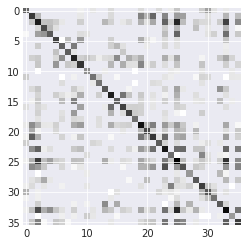

In [5]:
# obtaining mobility matrix from data
M = len(patches)
mobility_matrix = np.empty([0,M])
mobility_matrix = np.zeros((M,M))
k = 0
for i in range(M):
    for j in range(M):
        if OR_mobility_data.loc[k, 'County Name'] == patches[i]:
            if OR_mobility_data.loc[k, 'County Name.1'] == patches[j]:
                mobility_matrix[i,j] =  OR_mobility_data.loc[k, 'Workers in Commuting Flow']
                k +=1
mobility_matrix_norm = mobility_matrix / np.sum(mobility_matrix, axis=1, keepdims=True)
plt.imshow(np.log(mobility_matrix))

Let's look at contact network of Oregon on a map. The edges on the directed graph are weighted. Thicker edges indicate higher mobility flows between counties (nodes).

/gpfs/fs2/scratch/mgholiza/py0/py0/utils.py:794: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = np.column_stack((regions.centroid.x, regions.centroid.y))


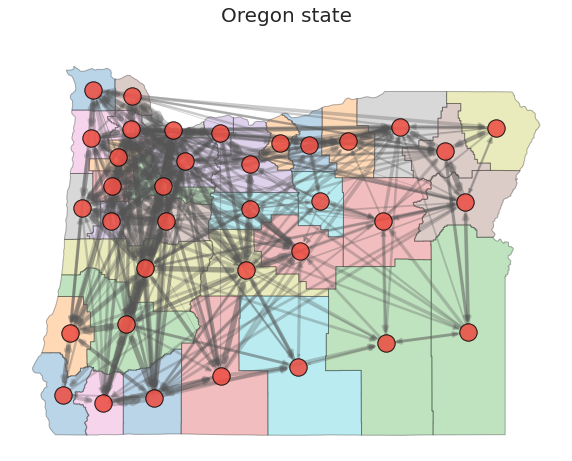

In [6]:
geojson_OR='data/Oregon_counties_map.geojson'
py0.draw_graph_on_map(mobility_matrix, geojson_OR, show_map_only=False, title='Oregon state', #ax=ax[0],
                 node_color='w', show_legend=False, figsize=(10,10), fontsize=20)

Let's define some synthetic diease parameters and generate a reference trajectory. This is done so that we can evalaute our model based on the true answer.

Plotting 36 patches in a 6 x 6 grid


<AxesSubplot:title={'center':'Yamhill County'}>

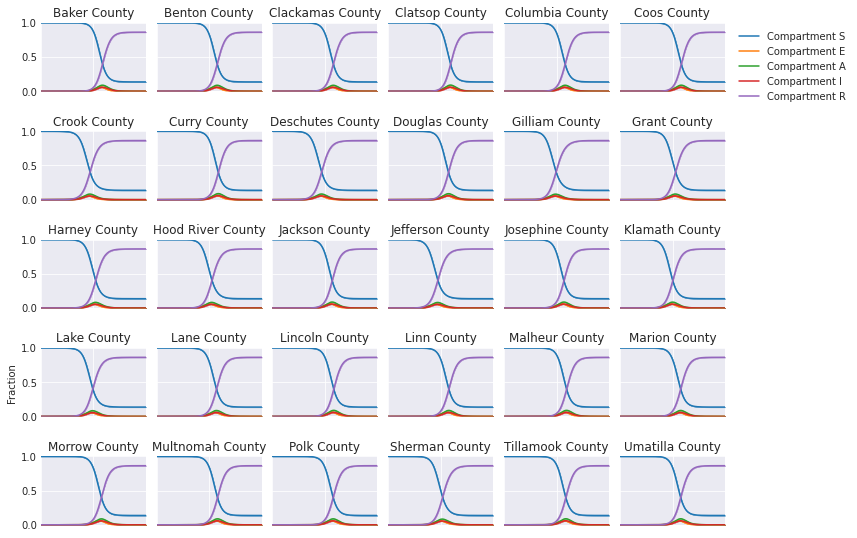

In [7]:
compartments = ['E', 'A', 'I', 'R']
full_compartments = ['S'] + compartments
infections_compartments = [1,2]
C = len(compartments)
tmat = py0.TransitionMatrix(compartments, [1,2])
eta = 1/2
mu = 1/5
epsilon = 0.4
tmat.add_transition('E', 'A', 1/eta/(1-epsilon), 0)
tmat.add_transition('E', 'I', 1/eta/epsilon, 0)
tmat.add_transition('A', 'R', 1/mu, 0)
tmat.add_transition('I', 'R', 1/mu, 0)
time = 200
infect_fxn = py0.contact_infection_func(infections_compartments, area=area)
model = py0.MetaModel(infect_fxn, time, populations=np.array(population))

# starting fractions probabilities
start = np.zeros((M,C)) #anywhere
# assume starting from Monroe county
true_p0_node = 6
exposed_true_node = 1/population[true_p0_node]
start[true_p0_node,0] = exposed_true_node
# start[0,0] = 0.05
beta = np.array([0.035,0.06])
ref_traj = model(mobility_matrix_norm, tmat.value, start, beta)[0]
ref_traj = ref_traj[np.newaxis,:,:,:]
py0.patch_quantile(ref_traj, patch_names = patches, figsize=(12, 9), alpha=0.5, names=['S','E','A','I','R'])
plt.gca()

We only take obervations (restraints) from this reference trajectory. 

In [46]:
prior = maxent.Laplace(1)
restrained_patches = [8, 10, 12, 26, 31]
restrained_compartments = [3,4]
npoints = 5
start_time = 70
end_time = 120
# Visualizing restraints
restraints, plot_fxns_list = py0.compartment_restrainer(restrained_patches, restrained_compartments,
                                                        ref_traj, prior, npoints = npoints, noise=0.05,
                                                        start_time=start_time, end_time=end_time, marker_size=10, marker_color='C0')

Restraints are set in this time range: [70, 120]
101 0.042809732 0.0430058699448721
80 0.02866371 0.028242209026593797
73 0.013787499 0.01377419176123256
108 0.025643667 0.024598580004441113
115 0.013159177 0.012940109889509563
94 0.42840618 0.4523772438234501
73 0.051360466 0.05375552622668819
101 0.6046124 0.5838658936264468
115 0.7974786 0.7966717050805162
80 0.11987437 0.1133292847756875
80 0.017256847 0.017826523734604915
94 0.050169438 0.05426253335432105
87 0.03415659 0.03338427887120696
115 0.021892102 0.02287730018113111
73 0.0072866594 0.00739973440782104
94 0.2930963 0.29286939991022953
101 0.47513792 0.4875332860949733
80 0.06283965 0.06502406191834337
73 0.024388263 0.024300184967114176
108 0.6344561 0.6073382745173824
80 0.00832845 0.007292238602768746
101 0.052993376 0.04954070677145866
108 0.05128516 0.05217080873660385
73 0.003281844 0.00321308399246563
115 0.035286363 0.03312342626473843
115 0.668962 0.6241262307172752
94 0.1655465 0.16521536314966245
87 0.07230322 0.

# Making ensemble of trajectories

Let's sample a distribution of epidemilogy parameters so we can apply MaxEnt.

In [40]:
tmat_sample = py0.TransitionMatrix(compartments, infections_compartments)
tmat_sample.add_transition('E', 'A', 2, 2) # call this alpha
tmat_sample.add_transition('E', 'I', 3, 2) # call this gamma
tmat_sample.add_transition('A', 'R',7, 3) # mu
tmat_sample.add_transition('I', 'R', 7, 3) # mu
print(tmat.value)
hyper_pram = py0.ParameterHypers()
hyper_pram.beta_low = [0.01, 0.03]
# hyper_pram.beta_low = 0.001
# hyper_pram.beta_high = 0.04
hyper_pram.beta_high = [0.05, 0.08]
hyper_pram.beta_var = [0.1]*2
# hyper_pram.start_high = 2e-4
hyper_pram.start_high = 2e-4
hyper_pram.R_var = 10
hyper_pram.beta_start = 0.04
hyper_pram.start_mean = 1e-5
# hyper_pram.start_scale = 1e-7
hyper_pram.start_scale = 1e-8
start_logits = np.zeros((M))
param_model = py0.MetaParameterJoint(start_logits, mobility_matrix , tmat_sample, name='unbiased_model',
                                          hypers = hyper_pram, n_infectious_compartments=2)

# run_sampling = True
# if run_sampling:
intial_exposed_guess = 1/np.array(population)
import tensorflow as tf
import tqdm
# N = 8192
#     N = 1024
N = 64
# batches = 32
batches = 64
total_batches= N*batches
outs = []
infect = py0.contact_infection_func(infections_compartments, area=area)
# model = maxentep.MetaModel(infect, Time,populations = np.round(population))
model = py0.MetaModel(infect, time, populations = population)
prior_prams = []
for b in tqdm.tqdm(range(batches)):
    ps = param_model.sample(N)
    start_dist = ps[2]
    new_start_dist = np.zeros_like(start_dist)
    start_dist_list = []
    for i in range(start_dist.shape[0]):
        index = tf.where(start_dist[i]>0)[0][0].numpy()
        new_start_dist[i,index,0] = intial_exposed_guess[index]
    start_dist_list.append(new_start_dist)
    outputs = tf.stack(start_dist_list, axis =0)
    ps[2] = tf.squeeze(outputs)
    prior_prams.append(ps)
    outs.append(model(*ps))
trajs = np.concatenate(outs, axis=0)
# else:
#     with open('OR_demo/OR.pckl', 'rb') as f:
#         traj_weights, trajs  = pickle.load(f)
# trajs = trajs[:,start_time:end_time,:,:]
print(trajs.shape)

[[0.5 0.3 0.2 0. ]
 [0.  0.8 0.  0.2]
 [0.  0.  0.8 0.2]
 [0.  0.  0.  1. ]]


100%|██████████| 64/64 [04:47<00:00,  4.49s/it]


(65536, 200, 36, 5)


/gpfs/fs2/scratch/mgholiza/py0/py0/utils.py:794: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if ax is None:


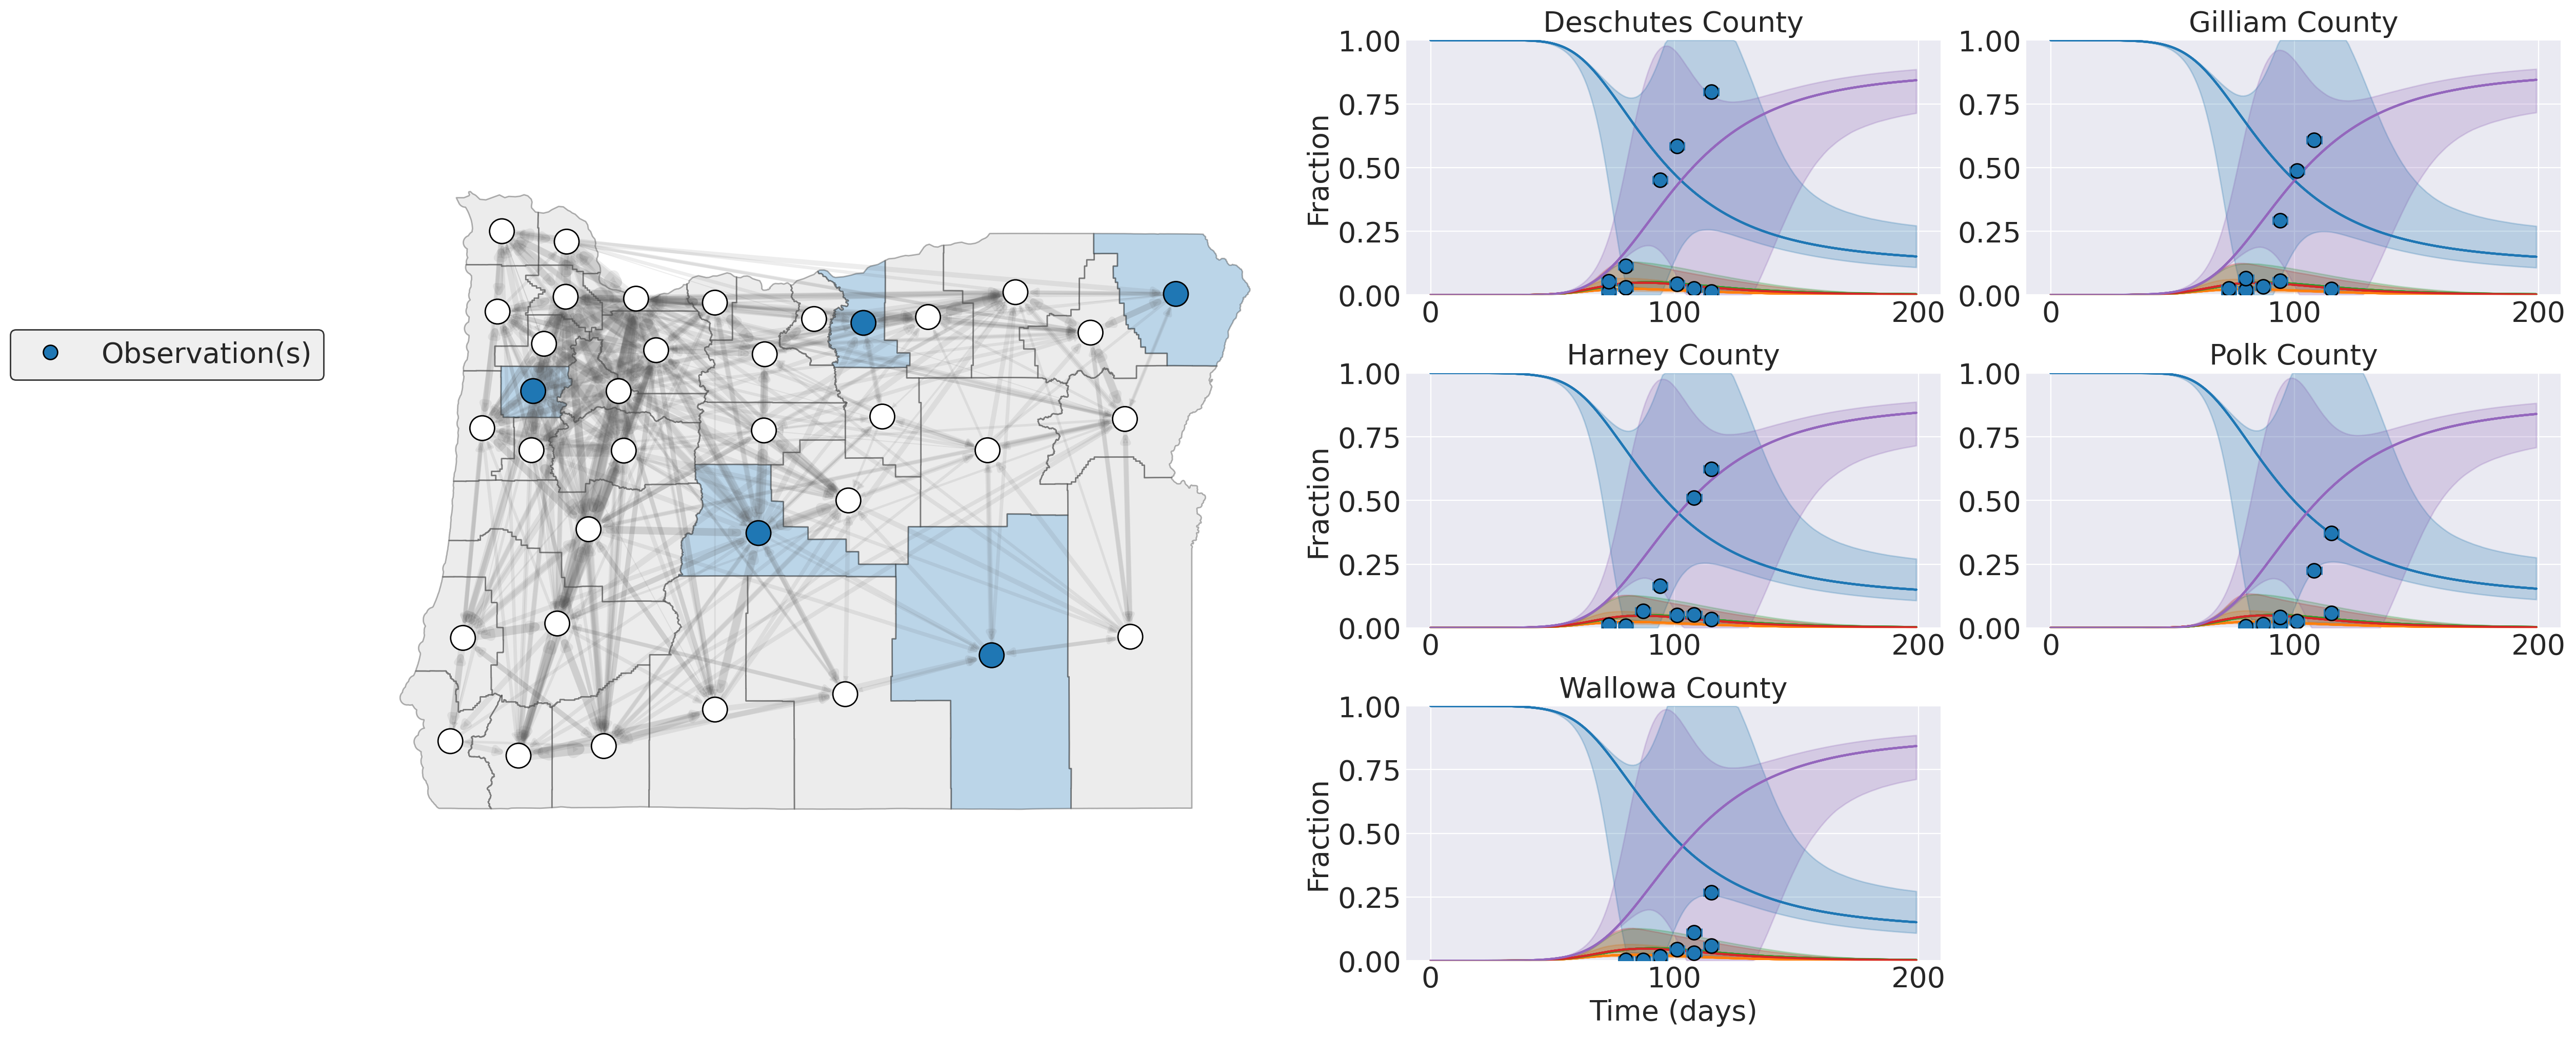

In [47]:
# visualizing obsevrations trajecotry samples
fig = plt.figure(constrained_layout=True, dpi=200,  figsize=(25, 10))
gs = fig.add_gridspec(3, 15)
font_size = 20
ax0 = fig.add_subplot(gs[:, :7])
ax1 = fig.add_subplot(gs[0, 7:11])
ax2 = fig.add_subplot(gs[0, 11:15])
ax3 = fig.add_subplot(gs[1, 7:11])
ax4 = fig.add_subplot(gs[1, 11:15])
ax5 = fig.add_subplot(gs[2, 7:11])
axes = [ax0, ax1, ax2, ax3, ax4, ax5]
names = ['S', 'E', 'A', 'I', 'R']
for j in range(0, 5):
    for i in range(trajs.shape[-1]):
    #     for n in range(trajs.shape[0]):
    #         axes[j+1].plot(trajs[n, :, restrained_patches[j], i], color=f'C{i}',
    #                        label=f'Compartment {names[i]}', linewidth=1, alpha=0.5)
        py0.traj_quantile(trajs[:,:,restrained_patches[j],:], weights=None, ax=axes[j+1],
                          alpha=0.05, add_legend=False, names=names, lower_q_bound=0.2, upper_q_bound=0.8) 
    for i, pf in enumerate(plot_fxns_list[j]):
        pf(axes[j+1], 0)
    axes[j+1].set_title(f'{patches[restrained_patches[j]]}',
                        fontsize=font_size)
    axes[j+1].set_xticks(np.arange(0, 200+1, 100))
    axes[j+1].tick_params(labelsize=font_size)
    axes[j+1].set_ylim([0, 1])
    if j == 4:
        axes[j+1].set_xlabel('Time (days)',  fontsize=font_size)
    if not j == 1 and not j == 3:
        axes[j+1].set_ylabel('Fraction',  fontsize=font_size)
# axes[4].legend()

# handles, labels = axes[4].get_legend_handles_labels()
# fig.legend(handles, labels, loc='lower right', bbox_to_anchor=[
#            0.95, 0.05], fontsize=font_size, fancybox=True)
# plt.tight_layout()

infection_origin = py0.exposed_finder(trajs)[0]
py0.draw_graph_on_map(mobility_matrix, geojson_OR, show_map_only=False,  # ax=ax[0],
                  node_color='w', show_legend=True, true_origin=None, restrained_patches=restrained_patches,
                  alpha_node=1, alpha_edge=0.1, ax=axes[0], figsize=(20, 20), node_size=300, fontsize=font_size)

# .text(19,19,f'Sample: {k}', fontsize=30 )
# axes[0].text(0.15, 0.1, f'Sample: {k}', size=30,
#              transform=plt.gcf().transFigure)

plt.savefig(
    f'prior.svg', dpi=200)
#     axes[0].clear()

# Applying MaxEnt

In [48]:
import geoplot.crs as gcrs
me_model = maxent.MaxentModel(restraints)
from tensorflow import keras
from keras.callbacks import ReduceLROnPlateau
optimizer=keras.optimizers.Adam(lr=1e-1) 
me_model.compile(optimizer=optimizer, loss='mean_squared_error')
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.9,
                          patience=50, min_lr=1e-4)
me_history = me_model.fit(trajs, batch_size=trajs.shape[0], epochs=200, callbacks=[reduce_lr])

/home/mgholiza/.conda/envs/covid-19/lib/python3.7/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/200
1/1 [==============================] - 0s 485ms/step - loss: 427.1397 - weight-entropy: 1.3696
Epoch 2/200
1/1 [==============================] - 0s 34ms/step - loss: 2.9755 - weight-entropy: 9.1830
Epoch 3/200
1/1 [==============================] - 0s 23ms/step - loss: 5.5906 - weight-entropy: 8.4928
Epoch 4/200
1/1 [==============================] - 0s 13ms/step - loss: 7.0564 - weight-entropy: 7.8303
Epoch 5/200
1/1 [==============================] - 0s 14ms/step - loss: 8.1309 - weight-entropy: 7.2877
Epoch 6/200
1/1 [==============================] - 0s 15ms/step - loss: 9.0266 - weight-entropy: 6.8476
Epoch 7/200
1/1 [==============================] - 0s 13ms/step - loss: 9.8065 - weight-entropy: 6.4877
Epoch 8/200
1/1 [==============================] - 0s 15ms/step - loss: 10.4616 - weight-entropy: 6.1911
Epoch 9/200
1/1 [==============================] - 0s 14ms/step - loss: 10.9259 - weight-entropy: 5.9454
Epoch 10/200
1/1 [==============================] - 0s 13ms

Epoch 79/200
1/1 [==============================] - 0s 13ms/step - loss: 3.3437 - weight-entropy: 3.4703
Epoch 80/200
1/1 [==============================] - 0s 12ms/step - loss: 3.3035 - weight-entropy: 3.4519
Epoch 81/200
1/1 [==============================] - 0s 13ms/step - loss: 3.2648 - weight-entropy: 3.4553
Epoch 82/200
1/1 [==============================] - 0s 13ms/step - loss: 3.2275 - weight-entropy: 3.4778
Epoch 83/200
1/1 [==============================] - 0s 14ms/step - loss: 3.1915 - weight-entropy: 3.5163
Epoch 84/200
1/1 [==============================] - 0s 12ms/step - loss: 3.1568 - weight-entropy: 3.5674
Epoch 85/200
1/1 [==============================] - 0s 12ms/step - loss: 3.1231 - weight-entropy: 3.6273
Epoch 86/200
1/1 [==============================] - 0s 16ms/step - loss: 3.0905 - weight-entropy: 3.6922
Epoch 87/200
1/1 [==============================] - 0s 12ms/step - loss: 3.0585 - weight-entropy: 3.7581
Epoch 88/200
1/1 [==============================] - 0s 

# Visualizing results

/home/mgholiza/.conda/envs/covid-19/lib/python3.7/site-packages/geoplot/geoplot.py:627: UserWarning: Cannot set "figsize" when passing an "ax" to the plot. To remove this warning omit the "figsize" parameter.
  'Cannot set "figsize" when passing an "ax" to the plot. To remove this '
/gpfs/fs2/scratch/mgholiza/py0/py0/utils.py:378: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  census_geo_points['geometry'] = census_geo_points['geometry'].centroid
/gpfs/fs2/scratch/mgholiza/py0/py0/utils.py:410: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/gpfs/fs2/scratch/mgholiza/py0/py0/utils.py:410: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.tight_l

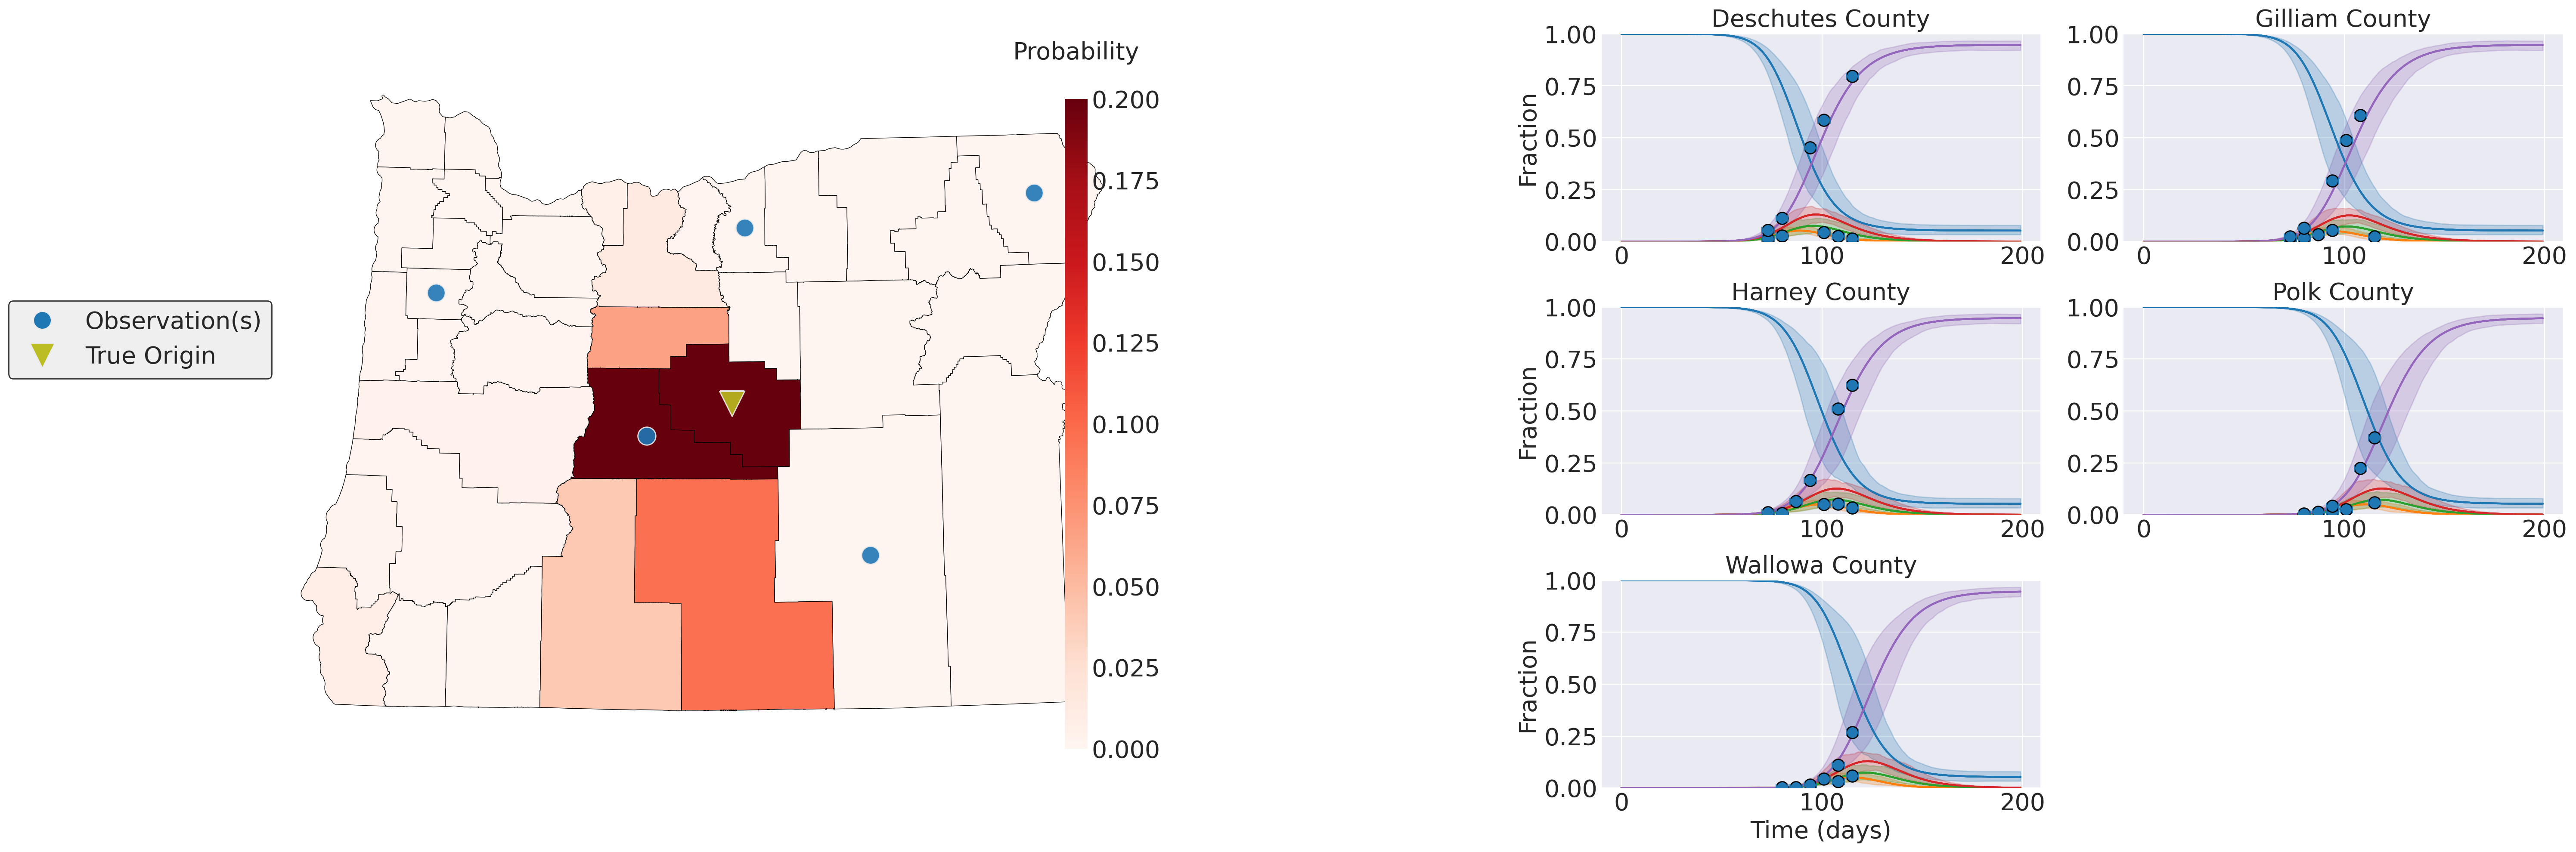

In [49]:
fig = plt.figure(constrained_layout=True, dpi=200,  figsize=(30, 10))
gs = fig.add_gridspec(3, 18)
projection = gcrs.AlbersEqualArea(
    central_longitude=-121, central_latitude=39.5)
ax0 = fig.add_subplot(gs[:, :7], projection=projection)
ax1 = fig.add_subplot(gs[0, 10:14])
ax2 = fig.add_subplot(gs[0, 14:18])
ax3 = fig.add_subplot(gs[1, 10:14])
ax4 = fig.add_subplot(gs[1, 14:18])
ax5 = fig.add_subplot(gs[2, 10:14])
axes = [ax0, ax1, ax2, ax3, ax4, ax5]
me_w = me_model.traj_weights
for j in range(0, 5):
    for i in range(trajs.shape[-1]):
        py0.traj_quantile(trajs[:,:,restrained_patches[j],:], weights=me_w, ax=axes[j+1],
                          alpha=0.05, add_legend=False, names=names, lower_q_bound=0.2, upper_q_bound=0.8)
    for i, pf in enumerate(plot_fxns_list[j]):
        pf(axes[j+1], 0)
    axes[j+1].set_title(f'{patches[restrained_patches[j]]}',
                        fontsize=font_size)
    axes[j+1].set_xticks(np.arange(0, 200+1, 100))
    axes[j+1].tick_params(labelsize=font_size)
    axes[j+1].set_ylim([0, 1])

    if j == 4:
        axes[j+1].set_xlabel('Time (days)',  fontsize=font_size)
    if not j == 1 and not j == 3:
        axes[j+1].set_ylabel('Fraction',  fontsize=font_size)
    # axes[4].legend()
#     if j == 0:
#         handles, labels = axes[4].get_legend_handles_labels()
#         fig.legend(handles, labels, loc='lower right', bbox_to_anchor=[
#                    0.94, 0.08], fontsize=font_size, fancybox=True)
prior_exposed_patch = py0.exposed_finder(trajs)
py0.p0_map(prior_exposed_patch, M, weights=me_w, patch_names=patches, fontsize=font_size,
       choropleth=True, geojson=geojson_OR,
       true_origin=true_p0_node, restrained_patches=restrained_patches, obs_size=15, vmin=0, vmax=0.2, figsize=(20, 20),
       show_cbar=True, show_legend=True, ax=axes[0])
plt.savefig(
    f'posterior.svg', dpi=200)